In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sxs
import qnmfits

### The `sxs` package lets us easily load SXS waveforms:

In [2]:
h = sxs.load('SXS:BBH:0305/Lev/rhOverM', extrapolation_order=2)
type(h)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


sxs.waveforms.waveform_modes.WaveformModes

The returned object is already a `WaveformModes` object, which has lots of handy methods (see the `scri` documentation [here](https://scri.readthedocs.io/en/latest/_autosummary/scri.html#scri.WaveformModes)).

In [3]:
# Shift the time array of the WaveformModes object so that zero is at the peak
h.t -= h.max_norm_time()

In [4]:
# We can also easily load metadata associated with the simulation
metadata = sxs.load('SXS:BBH:0305/Lev/metadata.json')

Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json


In [5]:
Mf = metadata.remnant_mass
chif = np.linalg.norm(metadata.remnant_dimensionless_spin)

### Perform a seven overtone fit to the $h_{22}$ mode using the `qnmfits` package:

In [6]:
spherical_mode = (2,2)
qnms = [(2,2,n,1) for n in range(7+1)]
t0 = 0

best_fit = qnmfits.ringdown_fit(
    h,
    spherical_mode,
    qnms,
    Mf=Mf,
    chif=chif,
    t0=t0
)

# The result is a dictionary with useful information
list(best_fit.keys())

['residual', 'mismatch', 'C', 'frequencies', 'data', 'model', 'times', 't0']

### Plot the best fit waveform and QNM amplitudes:

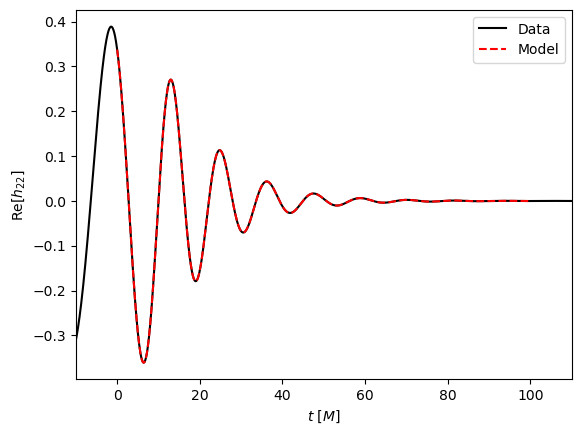

In [7]:
# Create figure
fig, ax = plt.subplots(dpi=100)

# The SXS data
ax.plot(h.t, np.real(h.data[:, h.index(2,2)]), 'k', label='Data')

# Our best fit model
ax.plot(best_fit['times'], np.real(best_fit['model']), 'r--', label='Model')

ax.set_xlim(t0-10, t0+110)

ax.set_xlabel('$t\ [M]$')
ax.set_ylabel(rf'$\mathrm{{Re}}[h_{{{spherical_mode[0]}{spherical_mode[1]}}}]$')

_ = ax.legend()

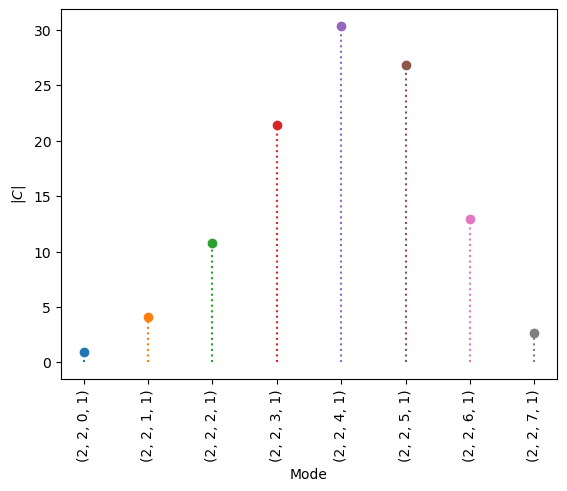

In [8]:
# Get the amplitudes from the complex coefficients
amplitudes = abs(best_fit['C'])

# x-axis values, useful for plotting
x = np.arange(len(amplitudes))

# Create figure
fig, ax = plt.subplots(dpi=100)

for i in range(len(amplitudes)):
    ax.plot(
        [x[i],x[i]], [0,amplitudes[i]], color=f'C{i}', marker='o', 
        markevery=(1,2), linestyle=':')

ax.set_xticks(x)
ax.set_xticklabels(qnms)
ax.tick_params(axis='x', rotation=90)

ax.set_xlabel('Mode')
_ = ax.set_ylabel('$|C|$')